In [49]:
!pip install pmdarima

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [51]:
# 1. Data Acquisition (using sample data for demonstration)
# Replace with actual BTC-USD data from a reliable source
df = pd.read_csv('/kaggle/input/asfdgjh/BTC-USD (5).csv', index_col='Date', parse_dates=True)
df = df[['Close']]

In [52]:
df

,Close
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005
...,...
2024-07-26,67912.062500
2024-07-27,67813.335938
2024-07-28,68255.867188


In [53]:
df['Close'] = df['Close'].fillna(66838.70)

In [54]:
df

,Close
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005
...,...
2024-07-26,67912.062500
2024-07-27,67813.335938
2024-07-28,68255.867188


In [55]:
df = df[df.index.weekday == 0]  # Get weekly data (Mondays)

In [56]:
# # Calculate Monday-to-Monday ROI
# df['ROI'] = df['Close'].pct_change() * 100
# df['ROI'] = df['ROI'].shift(-1)  # Shift ROI to predict *next* Monday

# Example lagged feature (you can add more)
df['Close_Lagged_1'] = df['Close'].shift(1) 
df.dropna(inplace = True)

df['ROI'] = ((df['Close']-df['Close_Lagged_1'])/df['Close_Lagged_1'])*100

/tmp/ipykernel_34/2817463365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_Lagged_1'] = df['Close'].shift(1)
/tmp/ipykernel_34/2817463365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)
/tmp/ipykernel_34/2817463365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI'] = 

In [57]:
df

,Close,Close_Lagged_1,ROI
Date,,,
2017-01-09,902.828003,1021.750000,-11.639050
2017-01-16,831.533997,902.828003,-7.896743
2017-01-23,921.012024,831.533997,10.760598
2017-01-30,920.382019,921.012024,-0.068404
2017-02-06,1038.150024,920.382019,12.795557
...,...,...,...
2024-07-01,62851.980469,60277.414063,4.271196
2024-07-08,56705.097656,62851.980469,-9.779935
2024-07-15,64870.152344,56705.097656,14.399155


In [58]:
# Split data (adjust ratios as needed)
train_data = df[:int(len(df)*0.7)]
val_data = df[int(len(df)*0.7):int(len(df)*0.85)]
test_data = df[int(len(df)*0.85):]

In [59]:
# train_data = df[:-8]
# val_data = df[-8:-4]
# test_data = df[-4:]

In [60]:
test_data

,Close,Close_Lagged_1,ROI
Date,,,
2023-06-12,25902.500000,25760.097656,0.552802
2023-06-19,26851.029297,25902.500000,3.661922
2023-06-26,30271.130859,26851.029297,12.737320
2023-07-03,31156.439453,30271.130859,2.924597
2023-07-10,30414.470703,31156.439453,-2.381430
2023-07-17,30145.888672,30414.470703,-0.883073
2023-07-24,29176.916016,30145.888672,-3.214278
2023-07-31,29230.111328,29176.916016,0.182320
2023-08-07,29180.578125,29230.111328,-0.169460


In [61]:
# Scale data (for LSTM)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['ROI']])
val_scaled = scaler.transform(val_data[['ROI']])
test_scaled = scaler.transform(test_data[['ROI']])

In [62]:
test_scaled

array([[0.46562617],
       [0.50276338],
       [0.61116545],
       [0.49395633],
       [0.43057792],
       [0.44847521],
       [0.42062988],
       [0.46120091],
       [0.45699904],
       [0.46835047],
       [0.32562711],
       [0.45820061],
       [0.44558365],
       [0.42895567],
       [0.53457703],
       [0.43867367],
       [0.51499368],
       [0.46131798],
       [0.4995458 ],
       [0.65028987],
       [0.51014746],
       [0.47754496],
       [0.50896602],
       [0.4909149 ],
       [0.45192246],
       [0.61054815],
       [0.43807418],
       [0.4989808 ],
       [0.48675526],
       [0.47420116],
       [0.53483211],
       [0.34564255],
       [0.37460274],
       [0.57333377],
       [0.4416511 ],
       [0.66341377],
       [0.50255994],
       [0.52230566],
       [0.761525  ],
       [0.52533591],
       [0.38325036],
       [0.50164303],
       [0.45464094],
       [0.49208336],
       [0.32220143],
       [0.52326893],
       [0.40547147],
       [0.446

In [63]:
# a) LSTM Model
def create_lstm_model(units=50, dropout_rate=0.2, optimizer='adam', look_back=3):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [64]:
model = create_lstm_model(50, 0.3, 'adam')
history = model.fit(train_scaled, train_data['ROI'], batch_size=32, epochs=120, validation_data=(val_scaled, val_data['ROI']))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 8.7080 - val_loss: 5.6982
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0554 - val_loss: 5.6996
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5662 - val_loss: 5.7013
Epoch 4/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2451 - val_loss: 5.7037
Epoch 5/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9944 - val_loss: 5.7061
Epoch 6/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.9019 - val_loss: 5.7100
Epoch 7/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2495 - val_loss: 5.7131
Epoch 8/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.3651 - val_loss: 5.7169
Epoch 9/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7140 - val_loss: 5.7218
Epoch 10/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7545 - val_loss: 5.7323
Epoch 11/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9958 - val_loss: 5.7555
Epoch 12/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9919 - val_loss: 5.7756


In [65]:
# Time series cross-validation for LSTM
tscv = TimeSeriesSplit(n_splits=3)

In [66]:
# b) Auto ARIMA Model
auto_arima_model = auto_arima(train_data['ROI'], seasonal=True, m=1, # Weekly seasonality
                              max_order = None, max_p =7, max_q = 7, max_d = 2,
                              max_P=4, max_D=2, max_Q=4, max_iter = 50, n_jobs = -1,
                              stationary=True, suppress_warnings=True, stepwise=True) # Optimize parameters

/opt/conda/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [67]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  276
Model:                        SARIMAX   Log Likelihood               -1061.999
Date:                Tue, 30 Jul 2024   AIC                           2127.998
Time:                        06:12:34   BIC                           2135.238
Sample:                    01-09-2017   HQIC                          2130.903
                         - 04-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9817      0.688      2.879      0.004       0.633       3.331
sigma2       128.7364      8.364     15.393      0.000     112.344     145.129
Ljung-Box (L1) (Q):                   0.88   Jarque-

In [68]:
# a) Predictions
# LSTM predictions
look_back = 1;
def lstm_predict(data):
    X = []
    # Start from look_back - 1 to avoid losing a sample
    for i in range(look_back - 1, len(data)):
        X.append(data[i-look_back+1:i+1])
    X = np.array(X)
    predictions = model.predict(X)
    return predictions

lstm_pred_val = lstm_predict(val_scaled)
lstm_pred_test = lstm_predict(test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [69]:
# Auto ARIMA predictions
arima_pred_val = auto_arima_model.predict(n_periods=len(val_data))
arima_pred_test = auto_arima_model.predict(n_periods=len(test_data))

In [70]:
# b) Ensemble # b) Ensemble Predictions (averaging)
# Adjust the length of arima_pred_val to match lstm_pred_val and reshape to 2D
ensemble_pred_val = (lstm_pred_val + arima_pred_val[-len(lstm_pred_val):].values.reshape(-1, 1)) / 2
ensemble_pred_test = (lstm_pred_test + arima_pred_test[-len(lstm_pred_test):].values.reshape(-1, 1)) / 2

In [71]:
# c) Calculate MAE
mae_lstm_val = mean_absolute_error(val_data['ROI'], lstm_pred_val)
mae_arima_val = mean_absolute_error(val_data['ROI'], arima_pred_val[-len(lstm_pred_val):].values.reshape(-1, 1))
mae_ensemble_val = mean_absolute_error(val_data['ROI'], ensemble_pred_val)

mae_lstm_test = mean_absolute_error(test_data['ROI'], lstm_pred_test)
mae_arima_test = mean_absolute_error(test_data['ROI'], arima_pred_test)
mae_ensemble_test = mean_absolute_error(test_data['ROI'], ensemble_pred_test)

print(f'Validation MAE LSTM: {mae_lstm_val:.3f}')
print(f'Validation MAE ARIMA: {mae_arima_val:.3f}')
print(f'Validation MAE Ensemble: {mae_ensemble_val:.3f}')

print(f'Test MAE LSTM: {mae_lstm_test:.3f}')
print(f'Test MAE ARIMA: {mae_arima_test:.3f}')
print(f'Test MAE Ensemble: {mae_ensemble_test:.3f}')

Validation MAE LSTM: 0.954
Validation MAE ARIMA: 6.134
Validation MAE Ensemble: 3.161
Test MAE LSTM: 0.458
Test MAE ARIMA: 5.043
Test MAE Ensemble: 2.423


In [72]:
test_data['ROI']

Date
2023-06-12     0.552802
2023-06-19     3.661922
2023-06-26    12.737320
2023-07-03     2.924597
2023-07-10    -2.381430
2023-07-17    -0.883073
2023-07-24    -3.214278
2023-07-31     0.182320
2023-08-07    -0.169460
2023-08-14     0.780880
2023-08-21   -11.167890
2023-08-28    -0.068864
2023-09-04    -1.125154
2023-09-11    -2.517245
2023-09-18     6.325354
2023-09-25    -1.703655
2023-10-02     4.685840
2023-10-09     0.192122
2023-10-16     3.392546
2023-10-23    16.012808
2023-10-30     4.280115
2023-11-06     1.550641
2023-11-13     4.181205
2023-11-20     2.669969
2023-11-27    -0.594469
2023-12-04    12.685640
2023-12-11    -1.753844
2023-12-18     3.345245
2023-12-25     2.321725
2024-01-01     1.270698
2024-01-08     6.346709
2024-01-15    -9.492202
2024-01-22    -7.067660
2024-01-29     9.570060
2024-02-05    -1.454386
2024-02-12    17.111539
2024-02-19     3.644889
2024-02-26     5.297998
2024-03-04    25.325391
2024-03-11     5.551689
2024-03-18    -6.343684
2024-03-25 

In [73]:
lstm_pred_test

array([[  0.15804318],
       [  3.7145452 ],
       [ 13.382151  ],
       [  2.8630652 ],
       [ -3.00347   ],
       [ -1.4238015 ],
       [ -3.8432243 ],
       [ -0.25540966],
       [ -0.64477557],
       [  0.41414842],
       [-10.120361  ],
       [ -0.53376913],
       [ -1.6844515 ],
       [ -3.1424084 ],
       [  6.766766  ],
       [ -2.299152  ],
       [  4.8958926 ],
       [ -0.24451292],
       [  3.4033365 ],
       [ 16.126354  ],
       [  4.4283624 ],
       [  1.2861156 ],
       [  4.31424   ],
       [  2.569502  ],
       [ -1.1105943 ],
       [ 13.335085  ],
       [ -2.3519127 ],
       [  3.3486948 ],
       [  2.1687741 ],
       [  0.9677626 ],
       [  6.7908583 ],
       [ -9.074244  ],
       [ -7.2984023 ],
       [ 10.293679  ],
       [ -2.035743  ],
       [ 16.941872  ],
       [  3.694868  ],
       [  5.5986347 ],
       [ 21.569267  ],
       [  5.888593  ],
       [ -6.707219  ],
       [  3.606176  ],
       [ -0.8618034 ],
       [  2

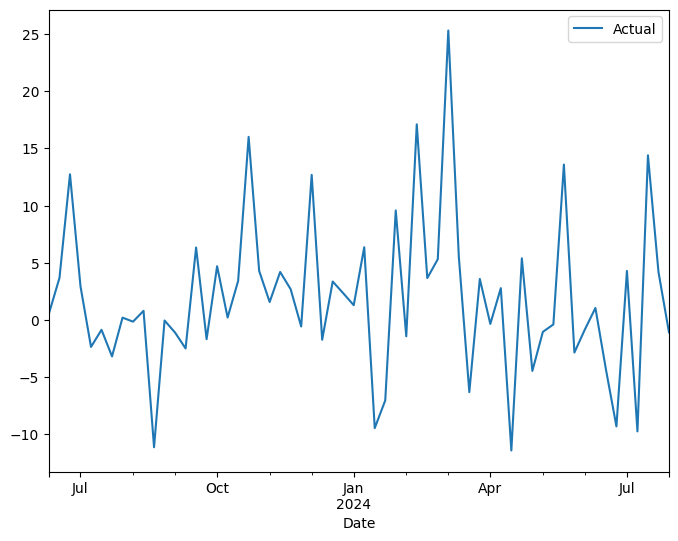

In [74]:
test_data['ROI'].plot(figsize=(8, 6))
plt.legend(['Actual'])
plt.show()

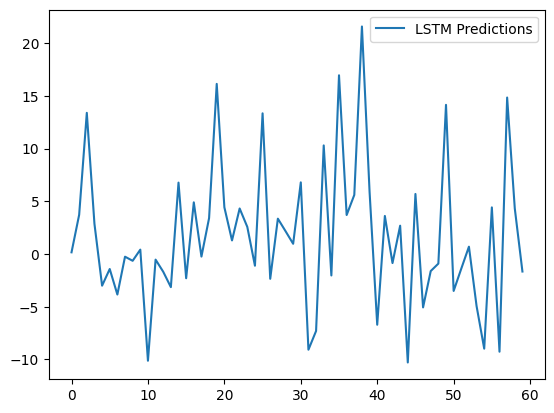

In [75]:
plt.plot(lstm_pred_test)
plt.legend(['LSTM Predictions'])
plt.show()

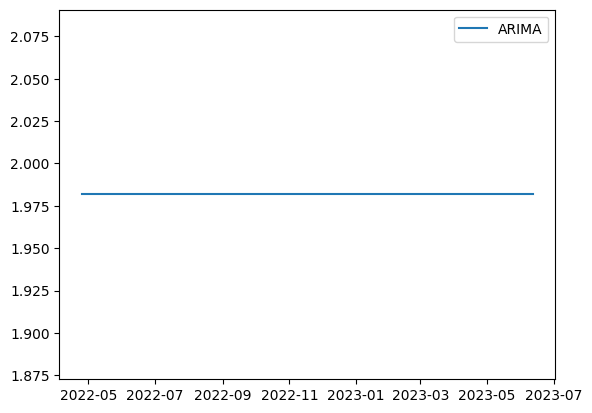

In [76]:
plt.plot(arima_pred_test)
plt.legend(['ARIMA'])
plt.show()

In [77]:
# Forecasting for the next four Mondays
def forecast_next_four_mondays(model, scaler, last_n_data, look_back=1, n_weeks=4):
    """Forecasts the ROI for the next four Mondays using a rolling window approach.

    Args:
        model: The trained LSTM model.
        scaler: The MinMaxScaler used to scale the data.
        last_n_data: The last 'n' weeks of scaled data (ROI values).
        look_back: The number of previous weeks used as input for the model.
        n_weeks: The number of future weeks (Mondays) to forecast.

    Returns:
        A list containing the forecasted ROI values for the next four Mondays.
    """

    forecasted_rois = []
    current_data = last_n_data  # Start with the last 'n' weeks of data

    for _ in range(n_weeks):
        # Reshape data for the model (samples, timesteps, features)
        input_data = current_data[-look_back:].reshape(1, look_back, 1)

        # Predict the next Monday's ROI
        next_roi = model.predict(input_data)[0][0]
        forecasted_rois.append(next_roi)

        # Update the current data for the next iteration (rolling window)
        current_data = np.append(current_data, next_roi)  # Add the prediction

    return forecasted_rois

# ... (Your existing code for LSTM and ARIMA model training and prediction)

# Example usage:
# Assuming 'test_scaled' contains the scaled ROI values for your test set
n = 7  # Use the last 7 weeks for forecasting
last_n_scaled_data = test_scaled[-n:]

# Get forecasts for the next four Mondays
forecasted_rois_lstm = forecast_next_four_mondays(model, scaler, last_n_scaled_data, look_back=1, n_weeks=5)

# Inverse transform to get the actual ROI values (if needed)
# forecasted_rois_actual = scaler.inverse_transform(np.array(forecasted_rois).reshape(-1, 1))

print(f"Forecasted ROIs for the next four Mondays (LSTM): {forecasted_rois_lstm}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Forecasted ROIs for the next four Mondays (LSTM): [-1.662402, -12.052461, -5.774539, -7.29405, -6.1494956]


In [78]:
# Classify ROI forecasts
def classify_roi(roi):
    if roi <= -8:
        return "Strong Bear"
    elif -8 < roi <= 0:
        return "Weak Bear"
    elif 0 < roi <= 6:
        return "Choppy"
    elif 6 < roi <= 16:
        return "Weak Bull"
    else:
        return "Strong Bull"


# Classify the forecasted ROIs
classified_forecasts_lstm = [classify_roi(roi) for roi in forecasted_rois_lstm]

print(f"Forecasted ROIs for the next four Mondays (LSTM): {forecasted_rois_lstm}")
print(f"Classified Forecasts (LSTM): {classified_forecasts_lstm}")

Forecasted ROIs for the next four Mondays (LSTM): [-1.662402, -12.052461, -5.774539, -7.29405, -6.1494956]
Classified Forecasts (LSTM): ['Weak Bear', 'Strong Bear', 'Weak Bear', 'Weak Bear', 'Weak Bear']


In [79]:
# Forecasting for the next four Mondays
def forecast_next_four_mondays(model, scaler, last_n_data, look_back=1, n_weeks=4):
    
    forecasted_rois = []
    current_data = last_n_data  # Start with the last 'n' weeks of data

    for _ in range(n_weeks):
        # Reshape data for the model (samples, timesteps, features)
        input_data = current_data[-look_back:].reshape(1, look_back, 1)

        # Predict the next Monday's ROI
        next_roi = model.predict(input_data)[0][0]
        forecasted_rois.append(next_roi)

        # Update the current data for the next iteration (rolling window)
        # 1. Reshape next_roi before scaling
        next_roi_reshaped = next_roi.reshape(-1, 1)  
        # 2. Scale the prediction
        next_roi_scaled = (next_roi_reshaped - df['ROI'].min(axis=0)) / (df['ROI'].max(axis=0) - df['ROI'].min(axis=0))
        # next_roi_scaled = scaler.transform(next_roi_reshaped)  
        # 3. Flatten the scaled prediction
        next_roi_scaled_flat = next_roi_scaled.flatten()
        # 4. Append the scaled, flattened prediction
        current_data = np.append(current_data, next_roi_scaled_flat) 

    return forecasted_rois

# ... (Your existing code for LSTM and ARIMA model training and prediction)

# Example usage:
# Assuming 'test_scaled' contains the scaled ROI values for your test set
n = 3  # Use the last 7 weeks for forecasting
last_n_scaled_data = test_scaled[-n:]

# Get forecasts for the next four Mondays
forecasted_rois_lstm = forecast_next_four_mondays(model, scaler, last_n_scaled_data, look_back=1, n_weeks=5)

# ... (Inverse transform forecasted_rois_lstm if needed to get actual ROI values)

print(f"Forecasted ROIs for the next four Mondays (LSTM): {forecasted_rois_lstm}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Forecasted ROIs for the next four Mondays (LSTM): [-1.662402, -2.2557182, -2.8741999, -3.5039086, -4.1281624]


In [80]:
# Forecasting for next Monday
def forecast_next_monday(model, scaler, last_n_data, look_back=1):
    """Forecasts the ROI for the next Monday based on the last 'last_n_data' weeks.

    Args:
        model: The trained LSTM model.
        scaler: The MinMaxScaler used to scale the data.
        last_n_data: The last 'n' weeks of scaled data (ROI values).
        look_back: The number of previous weeks used as input for the model.

    Returns:
        The forecasted ROI for the next Monday.
    """
    
    # Create input for the model using the last 'look_back' data points
    X = np.array([last_n_data[-look_back:]])
    
    # Get prediction from the model
    prediction = model.predict(X)[0][0]

    # Inverse transform to get the actual ROI value
    predicted_roi = scaler.inverse_transform([[prediction]])[0][0]
    
    return predicted_roi

# Get the last 'n' weeks of data from the scaled test data
n = 1  # Use the last 7 weeks for forecasting
last_n_scaled_data = forecasted_rois_lstm[-n:]

# Forecast the ROI for the next Monday
next_monday_roi = forecast_next_monday(model, scaler, last_n_scaled_data)

print(f"Forecasted ROI for the next Monday: {next_monday_roi:.4f}")

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None